In [1867]:
import pandas as pd
from scipy.stats import normaltest
import matplotlib.pyplot as plt
from time import time
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [1868]:
# чтение CSV-файла и создание DataFrame
train_df = pd.read_csv("train.csv", index_col=0)
train_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0


In [1869]:
train_df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [1870]:
# Преобразуем гендер, статус замужества в числовое значение
train_df_clean = train_df.replace({'gender': {'Male': 0, 'Other': 0.5, 'Female': 1}})
train_df_clean = train_df_clean.replace({'ever_married': {'Yes': 1, 'No': 0}})
dummies = pd.get_dummies(train_df['work_type'])
train_df_clean = train_df_clean.drop('work_type', axis=1)
train_df_clean = pd.concat([train_df_clean, dummies], axis=1)
train_df_clean = train_df_clean.replace({'Residence_type': {'Urban': 1, 'Rural': 0}})
train_df_clean = train_df_clean.replace({'smoking_status': {'never smoked': 0, 'Unknown': 0.33, 'formerly smoked': 0.66, 'smokes': 1}})
train_df_clean

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Govt_job,Never_worked,Private,Self-employed,children
id,,,,,,,,,,,,,,,
0,0.0,28.0,0,0,1,1,79.53,31.1,0.00,0,False,False,True,False,False
1,0.0,33.0,0,0,1,0,78.44,23.9,0.66,0,False,False,True,False,False
2,1.0,42.0,0,0,1,0,103.00,40.3,0.33,0,False,False,True,False,False
3,0.0,56.0,0,0,1,1,64.87,28.8,0.00,0,False,False,True,False,False
4,1.0,24.0,0,0,0,0,73.36,28.8,0.00,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,1.0,22.0,0,0,0,1,72.63,19.5,0.00,0,True,False,False,False,False
15300,1.0,46.0,1,0,1,1,101.19,32.1,0.00,0,False,False,True,False,False
15301,1.0,75.0,0,0,1,1,87.69,26.2,0.00,0,False,False,False,True,False


In [1871]:
cpearson_corr = pd.Series.abs(train_df_clean.corr(method='pearson')['stroke']) # корреляция по методу Пирсона
kendall_corr = pd.Series.abs(train_df_clean.corr(method='kendall')['stroke']) # корреляция по методу Кендалла
spearman_corr = pd.Series.abs(train_df_clean.corr(method='spearman')['stroke']) # корреляция по методу Спирмена
corr_result = pd.concat([cpearson_corr, kendall_corr, spearman_corr], keys=['pearson', 'kendall', 'spearman'], axis=1)
corr_result = corr_result.sort_values(by='kendall', ascending=False)[1:]
corr_result

,pearson,kendall,spearman
age,0.261320,0.211940,0.257773
hypertension,0.145895,0.145895,0.145895
ever_married,0.114010,0.114010,0.114010
heart_disease,0.111518,0.111518,0.111518
children,0.080381,0.080381,0.080381
Self-employed,0.076933,0.076933,0.076933
bmi,0.065393,0.061522,0.075166
avg_glucose_level,0.149273,0.040546,0.049645
smoking_status,0.032136,0.024556,0.026557
gender,0.014936,0.014932,0.014933


In [1872]:
# Проверка на наличие нормального распределения
columns_new = []
values_new = []
for column in train_df_clean.columns :
    p_value_factor = normaltest(train_df_clean[column]).pvalue
    columns_new.append(column)
    if p_value_factor > 0.05:
        values_new.append("+")
    else:
        values_new.append("-")
result = pd.DataFrame({'Фича': columns_new, 'имеет нормальное распределение': values_new})
result
# Проверка показала, что все поля не имеют нормального распределения,
# следовательно мы можем использвать либо корреляцию по методу Кендалла, либо по методу Спирмена.
# При этом, на таблице выше видно, что методы Кендалла и Спирмена имеют одинаковую последовательност


,Фича,имеет нормальное распределение
0,gender,-
1,age,-
2,hypertension,-
3,heart_disease,-
4,ever_married,-
5,Residence_type,-
6,avg_glucose_level,-
7,bmi,-
8,smoking_status,-
9,stroke,-


In [1873]:
features = kendall_corr[(kendall_corr > 0.1) | (kendall_corr == 1)]
features.sort_values(ascending=False)[1:]

age              0.211940
hypertension     0.145895
ever_married     0.114010
heart_disease    0.111518
Name: stroke, dtype: float64

In [1874]:
# избавление от незначащих фич
train_df_clean = train_df_clean.filter(features.index)

In [1875]:
# избавление от выбросов
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2.7, min_samples=3)
labels = dbscan.fit_predict(train_df_clean)
filtered_data = train_df_clean[labels != -1]
print(len(train_df_clean))
print(len(filtered_data))
train_df_clean_outlierless = filtered_data
train_df_clean_outlierless

15304
15304


,age,hypertension,heart_disease,ever_married,stroke
id,,,,,
0,28.0,0,0,1,0
1,33.0,0,0,1,0
2,42.0,0,0,1,0
3,56.0,0,0,1,0
4,24.0,0,0,0,0
...,...,...,...,...,...
15299,22.0,0,0,0,0
15300,46.0,1,0,1,0
15301,75.0,0,0,1,0


In [1876]:
# Очистка от лишних строк и подготовка данных
test_length_border = int(len(train_df_clean_outlierless) * 0.8)
test_df_clean_temp = train_df_clean_outlierless[test_length_border : ]
train_df_clean_temp = train_df_clean_outlierless[ : test_length_border]

x_train = train_df_clean_temp.drop(columns='stroke')
y_train = train_df_clean_temp['stroke']

x_test = test_df_clean_temp.drop(columns='stroke')
y_test = test_df_clean_temp['stroke']

x_train


,age,hypertension,heart_disease,ever_married
id,,,,
0,28.0,0,0,1
1,33.0,0,0,1
2,42.0,0,0,1
3,56.0,0,0,1
4,24.0,0,0,0
...,...,...,...,...
12238,29.0,0,0,1
12239,45.0,0,0,1
12240,51.0,0,0,1


In [1877]:
# выравнивание классов
import numpy as np

# субдескретизация уменьшением элементов до k где stroke = 0
k = 1
random_state = 42
zero_idx = np.array(y_train[y_train == 0].index)
subset_idx = np.random.RandomState(random_state).choice(zero_idx, size=int(k*len(zero_idx)), replace=False)

one_idx = np.array(y_train[y_train == 1].index)
c = np.concatenate((subset_idx, one_idx), axis=0)
x_train = x_train.loc[c].sort_index()
y_train = y_train.loc[c].sort_index()
print(len(x_train))

# передискретизация дублированием n раз элементов где stroke = 1
n = 0
for i in range(n) :
    x_train = np.concatenate((x_train, x_train.loc[one_idx]))
    y_train = np.concatenate((y_train, y_train.loc[one_idx]))
    print(len(x_train))
# не везде работает

# избавление от связей Томека (без импакта)
from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
print(len(x_train))
x_tomek, y_tomek = tomek.fit_resample(x_train, y_train)
x_train, y_train = x_tomek, y_tomek
print(len(x_tomek))

# сосредоточение к ближайшим соседям (долго думает)
# from imblearn.under_sampling import CondensedNearestNeighbour
# cnn = CondensedNearestNeighbour(random_state=42) 
# print(len(x_train))
# x_tomek, y_tomek = cnn.fit_resample(x_train, y_train)
# x_train, y_train = x_tomek, y_tomek
# print(len(x_tomek))

12243
12243
12243


In [1878]:

print(len(x_train))
print(len(y_train))

12243
12243


In [1879]:
# генерация искусственных данных с помощью SMOTE
smote = SMOTE(sampling_strategy=0.1)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
print(len(x_train_smote))
print("теперь равно нулю: ", len(y_train_smote[y_train_smote==0]))
print("изначально равно нулю: ", len(y_train[y_train==0]))
print("теперь равно еденице: ", len(y_train_smote[y_train_smote==1]))
print("изначально равно еденице: ", len(y_train[y_train==1]))
x_train = x_train_smote
y_train = y_train_smote

12894
теперь равно нулю:  11722
изначально равно нулю:  11722
теперь равно еденице:  1172
изначально равно еденице:  521


OptionError: No such keys(s): 'mode.use_inf_as_null'

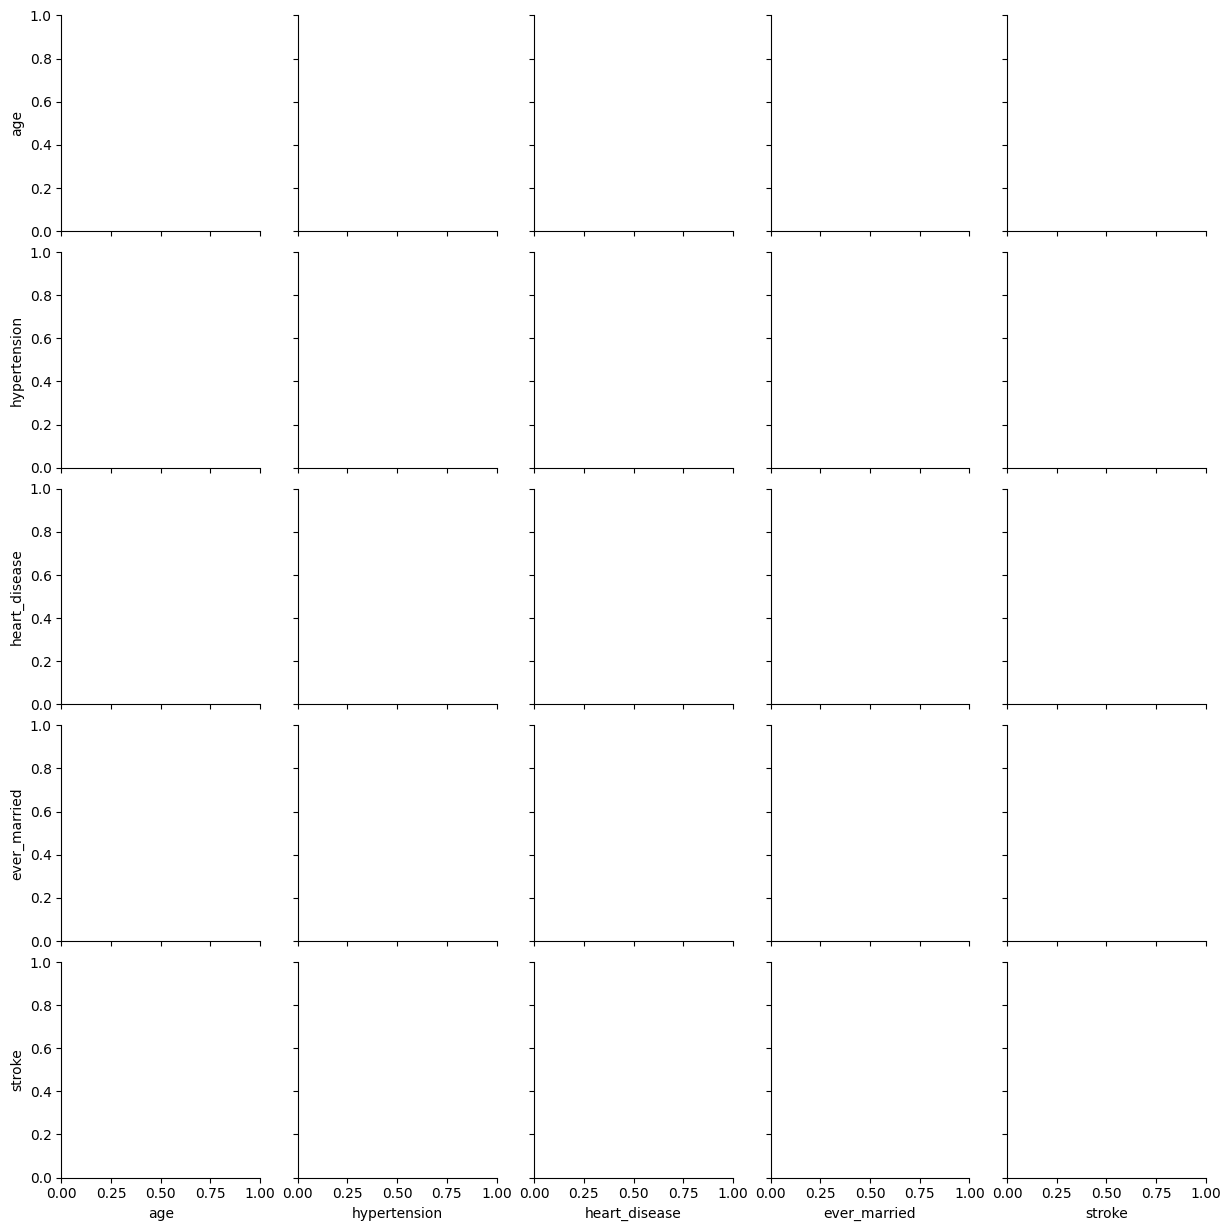

In [1880]:
# import seaborn
# pff = pd.concat([x_train, y_train], axis=1)
# seaborn.pairplot(pff)

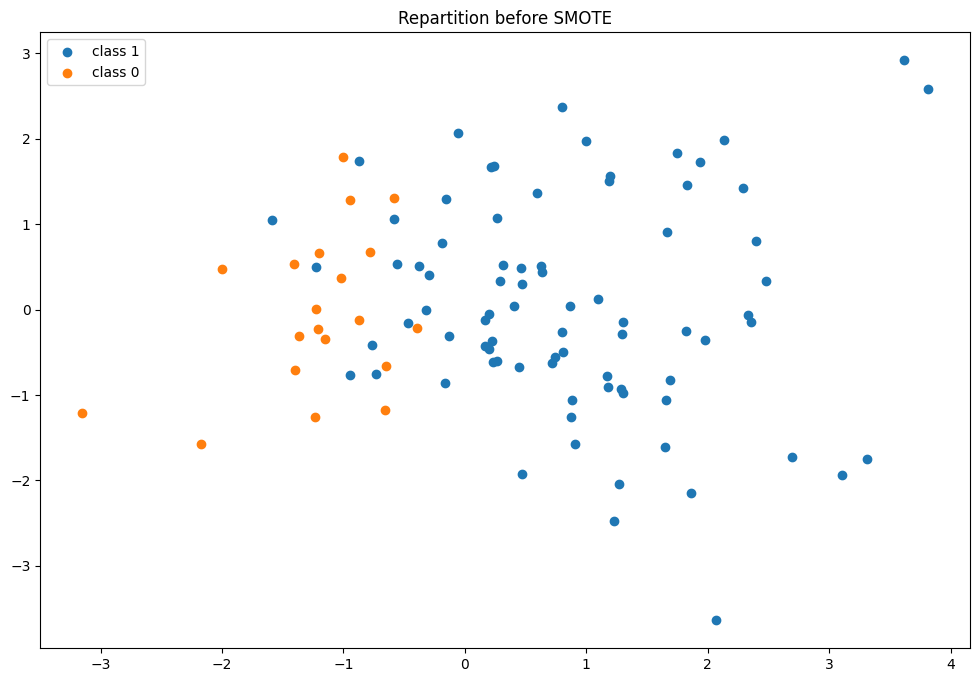

In [ ]:
# тесты
x_sample_train, y_sample_train = make_classification(n_samples=100, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2, weights=[0.2, 0.8],
                           class_sep=0.95, random_state=0)

plt.figure(figsize=(12, 8))
plt.title('Repartition before SMOTE')
plt.scatter(x_sample_train[y_sample_train == 1][:, 0], x_sample_train[y_sample_train == 1][:, 1], label='class 1')
plt.scatter(x_sample_train[y_sample_train == 0][:, 0], x_sample_train[y_sample_train == 0][:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

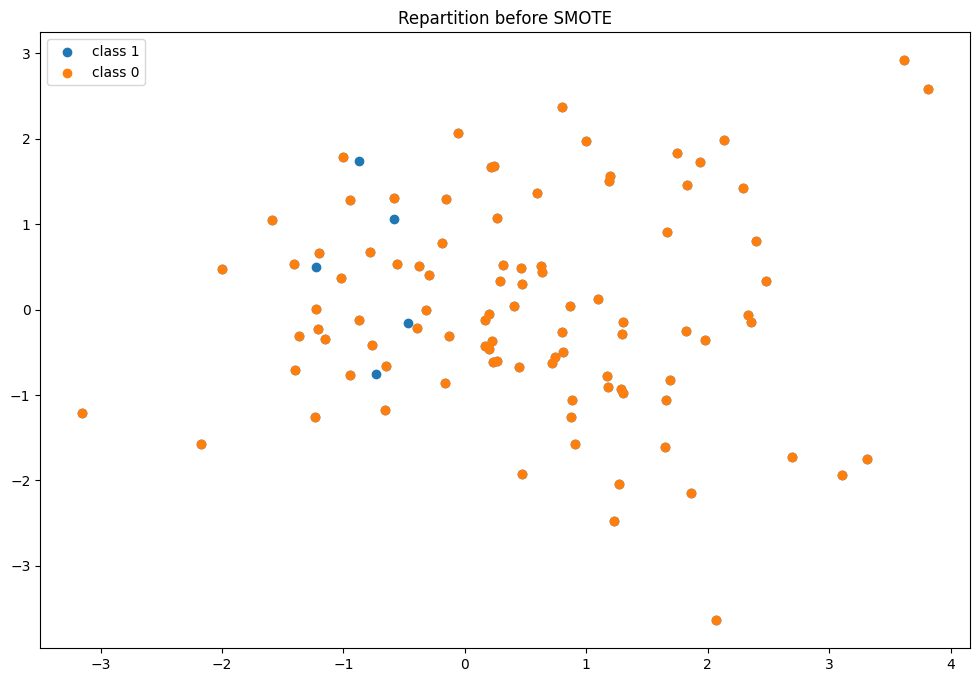

In [ ]:



# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# labels = dbscan.fit_predict(x_sample_train)
# filtered_data = x_sample_train[labels != -1]
# print(len(x_sample_train))
# print(len(filtered_data))

from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
X_tomek, y_tomek = tomek.fit_resample(x_sample_train, y_sample_train)


plt.figure(figsize=(12, 8))
plt.title('Repartition before SMOTE')
plt.scatter(x_sample_train[:, 0], x_sample_train[:, 1], label='class 1')
plt.scatter(X_tomek[:, 0], X_tomek[:, 1], label='class 0')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
# naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

# создаем объект модели
nb = GaussianNB()

nb.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = nb.predict(x_test)

# оцениваем точность прогнозов
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("precision: ", precision)
print('Accuracy:', accuracy)
print('Recall:', accuracy)
print('roc_auc: ', roc_auc)
# precision:  0.14736842105263157


precision:  0.14736842105263157
Accuracy: 0.9199607971251225
Recall: 0.9199607971251225
roc_auc:  0.5986684990074821


In [ ]:
x_test

,age,hypertension,heart_disease,ever_married
id,,,,
12243,51.0,0,0,1
12244,52.0,0,0,1
12245,8.0,0,0,0
12246,26.0,0,0,0
12247,63.0,1,0,1
...,...,...,...,...
15299,22.0,0,0,0
15300,46.0,1,0,1
15301,75.0,0,0,1


In [ ]:
from sklearn.linear_model import LogisticRegression

# создаем объект модели
lr_model = LogisticRegression()

# обучаем модель на обучающей выборке
lr_model.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = lr_model.predict(x_test)

# оцениваем точность прогнозов
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("precision: ", precision)
print('Accuracy:', accuracy)
print('Recall:', accuracy)
print('roc_auc: ', roc_auc)
# precision:  0.5
# Accuracy: 0.9601437438745508
# Recall: 0.9601437438745508
# roc_auc:  0.5501557489693083

precision:  0.27586206896551724
Accuracy: 0.9552433845148645
Recall: 0.9552433845148645
roc_auc:  0.5649534280042755


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# создаем объект модели
lr_model = DecisionTreeClassifier()

# обучаем модель на обучающей выборке
lr_model.fit(x_train, y_train)

# делаем прогнозы на тестовой выборке
y_pred = lr_model.predict(x_test)

# оцениваем точность прогнозов
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("precision: ", precision)
print('Accuracy:', accuracy)
print('Recall:', accuracy)
# precision:  0.25

precision:  0.3170731707317073
Accuracy: 0.953936622018948
Recall: 0.953936622018948


In [ ]:
from lightgbm import LGBMClassifier

lgbm_hyperparameters = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2,],
    'num_leaves': [2, 6, 10, 14, 18, 20],
    'max_depth': [2, 6, 8,  12,  16,  20],
    'min_child_samples': [2, 4,  8, 12, 16,  20],
    'subsample': [0.5, 0.6, 0.8, 1],
}
# clf = LGBMClassifier(random_state=seed, n_jobs=-1)
# grid_search = GridSearchCV(clf, lgbm_hyperparameters, cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(train_X, train_y)
# print(grid_search.best_params_)

best_params_lgbm = {'learning_rate': 0.05, 'max_depth': 6, 'min_child_samples': 12, 'n_estimators': 100, 'num_leaves': 6, 'subsample': 0.5}
lgbm_model = LGBMClassifier(random_state=321, n_jobs=-1, **best_params_lgbm)
lgbm_model.fit(x_train, y_train)


# делаем прогнозы на тестовой выборке
y_pred = lgbm_model.predict(x_test)

# оцениваем точность прогнозов
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("precision: ", precision)
print('Accuracy:', accuracy)
print('Recall:', accuracy)

precision:  0.3283582089552239
Accuracy: 0.9562234563868017
Recall: 0.9562234563868017


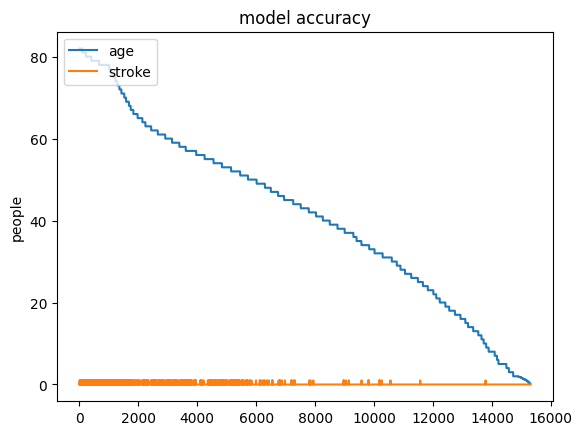

In [ ]:
import matplotlib.pyplot as plt

draw_dp = train_df.sort_values(by='age', ascending=False)
plt.plot(range(len(draw_dp)), draw_dp['age'], )
plt.plot(range(len(draw_dp)), draw_dp['stroke'])
plt.title('model accuracy')
plt.ylabel('people')
plt.legend(['age', 'stroke'], loc='upper left')
plt.show()

632
14672


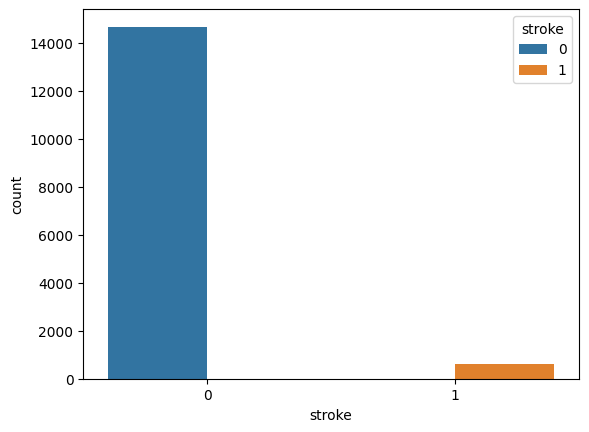

In [ ]:
import seaborn as sns
sns.countplot(x = 'stroke', hue = 'stroke', data = train_df)
print(len(train_df[train_df['stroke'] > 0]))
print(len(train_df[train_df['stroke'] == 0]))